# Image Segmentation and Feature Extraction Workflow

In this notebook, we will develop an image-segmentation workflow for processing images from the BBBC007v1 image set (Jones et al., Proc. ICCV Workshop on Computer Vision for Biomedical Image Applications, 2005), available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012]. We will extract features from the segmented images, visualize relationships between these features, and identify which features are strongly correlated and which are not.

## Planned Steps
1. Import necessary libraries.
2. Load images and corresponding label images.
3. Preprocess images (e.g., normalization).
4. Perform image segmentation to produce label images.
5. Measure the quality of segmentation results using the Jaccard index.
6. Extract features from the segmented images.
7. Visualize relationships between the features.
8. Identify strongly correlated features.
9. Save extracted features and segmentation results.
10. Document the workflow, algorithms, and results.

## Installation Instructions
To set up the environment, you need to install the following packages. You can use `conda` or `pip` for installation:

### Using conda:
```sh
conda create -n bioimage_analysis python=3.8
conda activate bioimage_analysis
conda install numpy pandas scikit-image matplotlib seaborn
pip install stackview the-segmentation-game
```

### Using pip:
```sh
pip install numpy pandas scikit-image matplotlib seaborn stackview the-segmentation-game
```


In [1]:
# Step 1: Import necessary libraries
import os
import numpy as np
import pandas as pd
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.measure
import skimage.segmentation
import matplotlib.pyplot as plt
import seaborn as sns
import stackview
from the_segmentation_game import metrics

### Step 2: Load images and corresponding label images

We will load all .tif files from the specified image and label directories.

In [2]:
image_folder = '../05b_quality_assurance/data/BBBC007_batch/'
label_folder = '../05b_quality_assurance/data/BBBC007_sparse_instance_annotation/'

def load_images(image_folder, label_folder):
    images = {}
    labels = {}
    for filename in os.listdir(image_folder):
        if filename.endswith('.tif'):
            image_path = os.path.join(image_folder, filename)
            label_path = os.path.join(label_folder, filename)
            images[filename] = skimage.io.imread(image_path)
            labels[filename] = skimage.io.imread(label_path)
    return images, labels

images, labels = load_images(image_folder, label_folder)
print(f"Loaded {len(images)} images and {len(labels)} label images.")

Loaded 6 images and 6 label images.


### Step 3: Preprocess images (e.g., normalization)

Normalize the images to have values between 0 and 1.

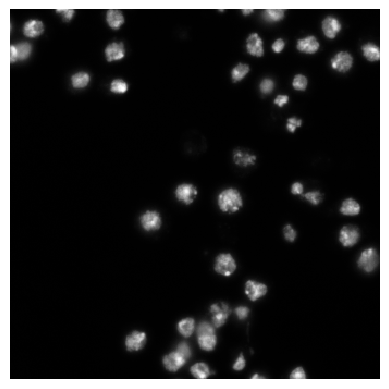

In [3]:
def normalize_images(images):
    normalized_images = {}
    for key, image in images.items():
        normalized_images[key] = image / np.max(image)
    return normalized_images

normalized_images = normalize_images(images)
stackview.imshow(list(normalized_images.values())[0])

### Step 4: Perform image segmentation to produce label images

We will use a simple thresholding algorithm to segment the images.

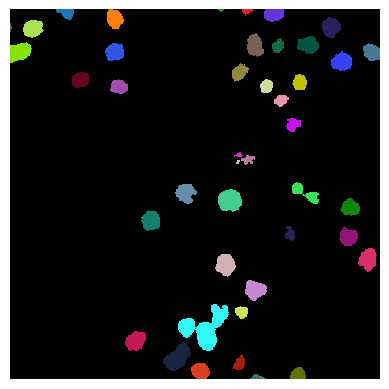

In [4]:
def segment_images(images):
    segmented_images = {}
    for key, image in images.items():
        threshold = skimage.filters.threshold_otsu(image)
        binary_image = image > threshold
        segmented_image = skimage.morphology.label(binary_image)
        segmented_images[key] = segmented_image
    return segmented_images

segmented_images = segment_images(normalized_images)
stackview.imshow(segmented_images[next(iter(segmented_images))])

### Step 5: Measure the quality of segmentation results using the Jaccard index

Compare the segmented images with the ground truth label images.

In [5]:
jaccard_indices = {}
for key in segmented_images.keys():
    jaccard_indices[key] = metrics.jaccard_index_sparse(labels[key], segmented_images[key])
jaccard_indices_df = pd.DataFrame.from_dict(jaccard_indices, orient='index', columns=['Jaccard Index'])
display(jaccard_indices_df)

,Jaccard Index
17P1_POS0013_D_1UL.tif,0.553488
20P1_POS0005_D_1UL.tif,0.675461
20P1_POS0007_D_1UL.tif,0.672551
20P1_POS0010_D_1UL.tif,0.545285
A9 p7d.tif,0.407462
AS_09125_040701150004_A02f00d0.tif,0.335184


### Step 6: Extract features from the segmented images

We will extract features such as area, perimeter, eccentricity, and mean intensity of the segmented objects.

In [6]:
def extract_features(images, segmented_images):
    features = []
    for key, image in images.items():
        regions = skimage.measure.regionprops(segmented_images[key], intensity_image=image)
        for region in regions:
            features.append({
                'Image': key,
                'Label': region.label,
                'Area': region.area,
                'Perimeter': region.perimeter,
                'Eccentricity': region.eccentricity,
                'Mean Intensity': region.mean_intensity
            })
    return pd.DataFrame(features)

features_df = extract_features(normalized_images, segmented_images)
display(features_df.head())

,Image,Label,Area,Perimeter,Eccentricity,Mean Intensity
0,17P1_POS0013_D_1UL.tif,1,114.0,44.142136,0.845116,0.417200
1,17P1_POS0013_D_1UL.tif,2,218.0,54.041631,0.584506,0.375967
2,17P1_POS0013_D_1UL.tif,3,11.0,10.242641,0.890818,0.284492
3,17P1_POS0013_D_1UL.tif,4,45.0,25.278175,0.860287,0.370196
4,17P1_POS0013_D_1UL.tif,5,194.0,53.349242,0.799463,0.395128


### Step 7: Visualize relationships between the features

We will use pair plots to visualize the relationships between different features.

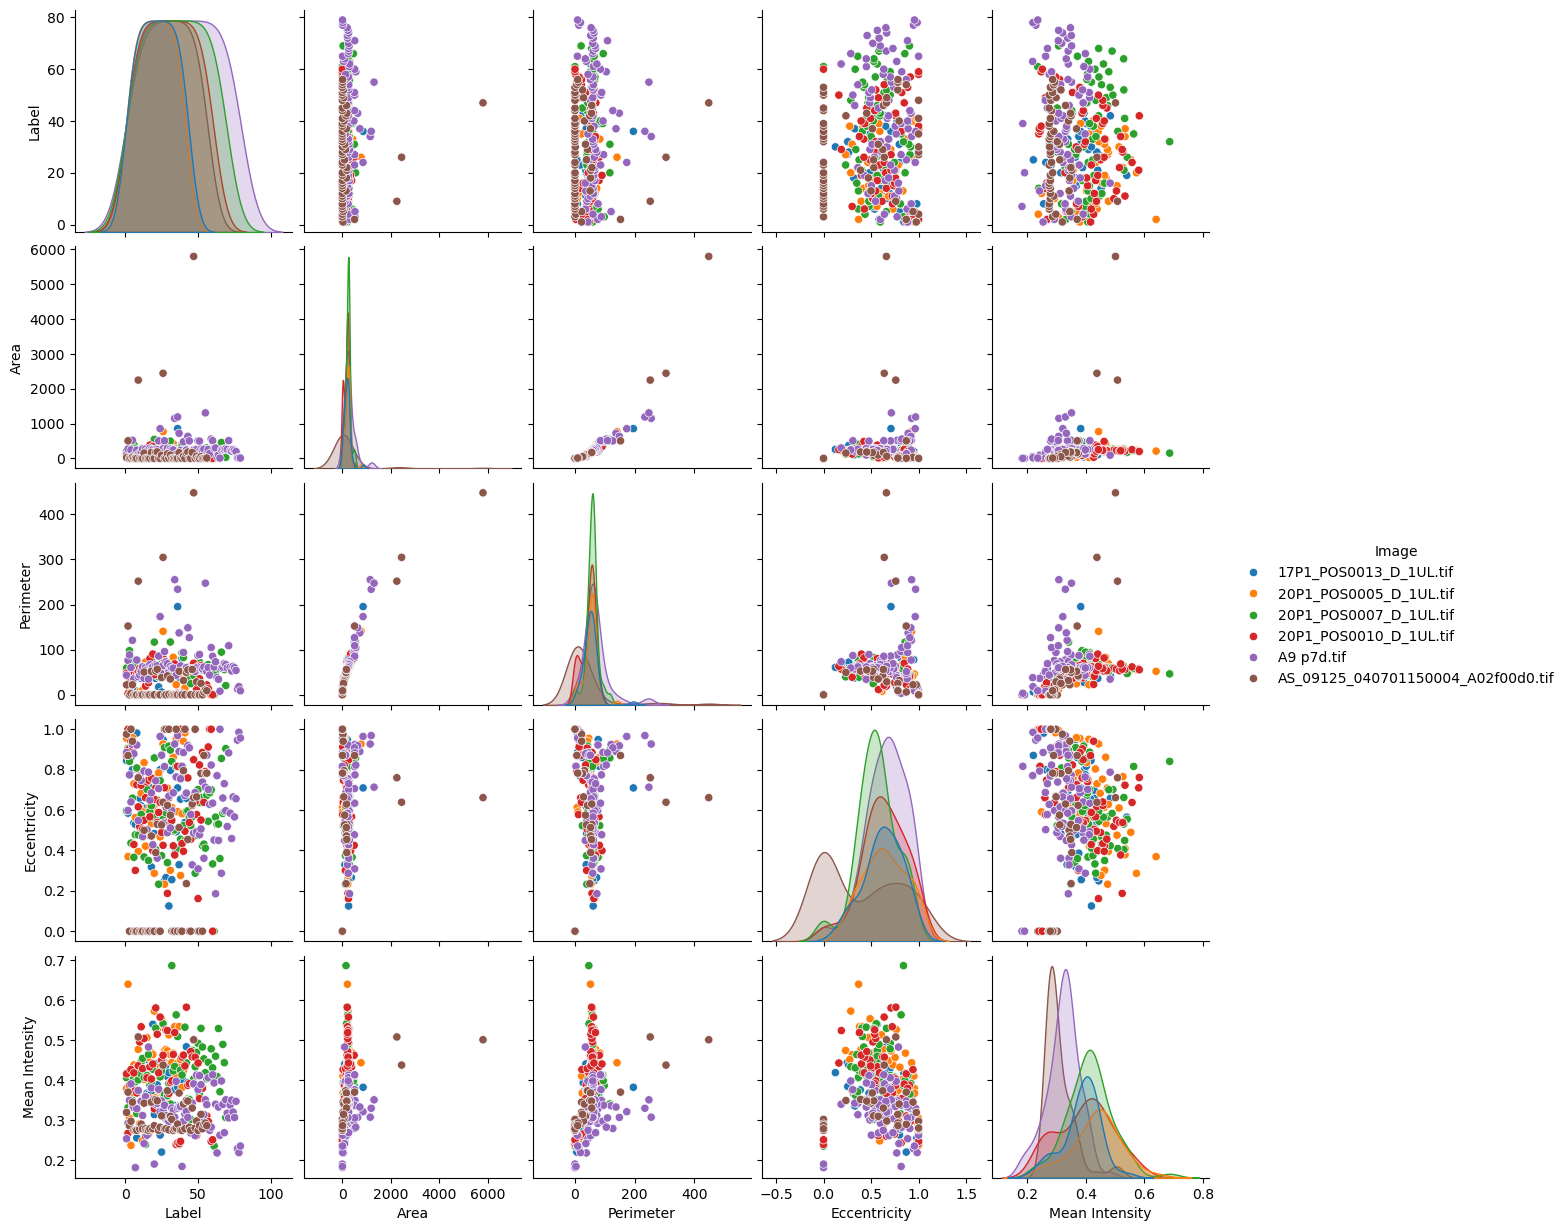

In [7]:
sns.pairplot(features_df, hue='Image')
plt.show()

### Step 8: Identify strongly correlated features

We will compute the correlation matrix to identify strongly correlated features.

In [8]:
correlation_matrix = features_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

ValueError: could not convert string to float: '17P1_POS0013_D_1UL.tif'

### Step 9: Save extracted features and segmentation results

We will save the extracted features to a CSV file and the segmentation results as label images.

In [ ]:
features_df.to_csv('extracted_features.csv', index=False)

output_label_folder = './segmentation_results/'
os.makedirs(output_label_folder, exist_ok=True)

for key, segmented_image in segmented_images.items():
    output_path = os.path.join(output_label_folder, key)
    skimage.io.imsave(output_path, segmented_image.astype(np.uint16))
print(f"Features saved to 'extracted_features.csv' and segmentation results saved to '{output_label_folder}'")

### Step 10: Document the workflow, algorithms, and results

In this workflow, we implemented an image-segmentation and feature extraction pipeline for the BBBC007v1 image set using a simple thresholding algorithm for segmentation. We measured the quality of the segmentation using the Jaccard index, extracted features from the segmented images, and visualized the relationships between these features. The extracted features and segmentation results were saved for further analysis.

#### Thresholding Algorithm:
Thresholding is a simple technique for image segmentation that converts a grayscale image into a binary image based on a certain threshold. The threshold value can be determined using methods like Otsu's method, which minimizes the intra-class variance of the thresholded black and white pixels. This method is effective for images with clear foreground-background contrast.

#### Jaccard Index:
The Jaccard index measures the similarity between two sets by comparing the intersection and union of the sets. For image segmentation, it quantifies the overlap between the predicted segmentation and the ground truth labels.

#### Feature Extraction:
We extracted several features from the segmented objects, including area, perimeter, eccentricity, and mean intensity. These features provide insights into the morphology and intensity characteristics of the segmented objects.

#### Visualizations:
Pair plots and correlation matrices are used to visualize and identify relationships between the extracted features, providing a comprehensive understanding of the feature space.